In [1]:
#SG3 07/07/2020
import argparse
import traceback
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

In [2]:

data = pd.read_excel('/Users/kkwock/GH_OneDrive/Data/Spark/20211013_Spark_9618_kk10.xlsx',header = None)
job_id = 'TEST'

NameError: name 'conversion_eq' is not defined

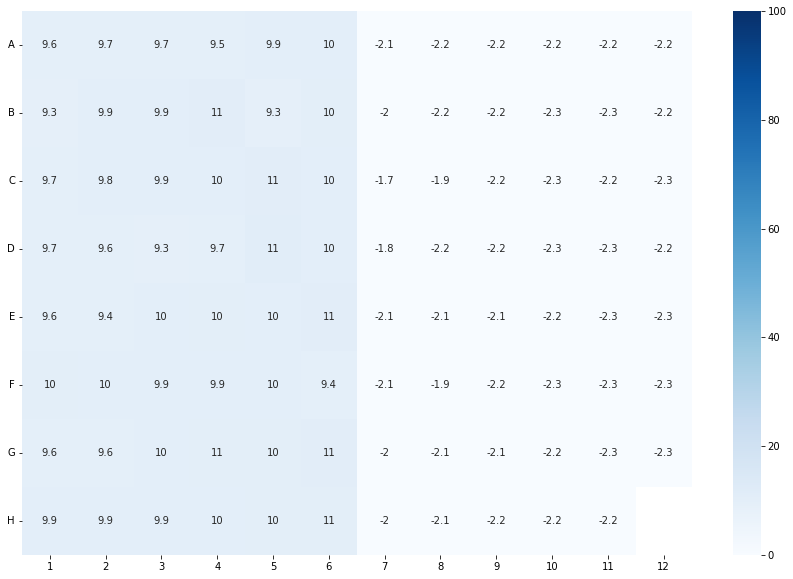

In [3]:
abs_readings_index = list()

for i in range(0,len(data)):
    #print(data[0][i])
    if data[0][i] == 'Measurement wavelength [nm]':
        abs_readings_index.append(i)
        
index_range = range(0,len(abs_readings_index))
abs_wavelen_dict = pd.DataFrame(index = index_range ,columns = ['wavelen_index' , 'abs_nm' ])
        
        
for j in range(0,len(abs_readings_index)):
    abs_wavelen_dict.wavelen_index[j] = abs_readings_index[j]
    abs_wavelen_dict.abs_nm[j] = data.loc[abs_readings_index[j]][4]

for i in range(0,len(abs_wavelen_dict)):
    if abs_wavelen_dict.abs_nm[i] == 260:
        index_260nm_start = int(abs_wavelen_dict.wavelen_index[i] + 9)
        index_260nm_end = index_260nm_start+95
    if abs_wavelen_dict.abs_nm[i] == 320:
        index_320nm_start = int(abs_wavelen_dict.wavelen_index[i] + 9)
        index_320nm_end = index_320nm_start+95
        
wavelen_260_df = data.loc[index_260nm_start:index_260nm_end][[0,1]]
wavelen_260_df.columns =['Well','Value']
wavelen_320_df = data.loc[index_320nm_start:index_320nm_end][[0,1]]
wavelen_320_df.columns =['Well','Value']


wavelen_260_df.reset_index(inplace=True, drop=True)
wavelen_320_df.reset_index(inplace=True, drop=True)

well_vol_ul = 40

concentration_df = pd.DataFrame(index = range(0,96), columns = ['Well','Value'])
concentration_df.Well = wavelen_260_df.Well
                  
for i in range(0,96):
    concentration_df.Value[i] = (wavelen_260_df.Value[i] - 0.0777 - (wavelen_320_df.Value[i] - 0.0433)) * np.pi * 4.69**2 / (0.008* well_vol_ul)
    
concentration_df.reset_index(inplace=True, drop=True)

spark_HDF = pd.DataFrame()

for index in range(0,95):
    #try:
    individual_row_char = str(concentration_df.Well[index][0])
    individual_col_int = int(concentration_df.Well[index][1:])
    spark_HDF.loc[individual_row_char, individual_col_int] = float(concentration_df.Value[index])


F, AX = plt.subplots(figsize=(15,10))
AX = sns.heatmap(spark_HDF, annot=True, cmap = ('Blues'), vmin = 0 , vmax = 100)
AX.set_ylim(top=8, bottom=.01)
AX.invert_yaxis()

plt.yticks(rotation = 0)
plt.title('Concentration ng/uL Speak Abs Heatmap \n\n {0} \n'.format(conversion_eq))
plt.savefig('spark_quant_heatmap_{0}.pdf'.format(job_id))

